In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import os.path as osp

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import os
import json
import numpy as np
from PIL import Image
from torchvision import transforms

class UECFoodPixDataset(Dataset):
    def __init__(self, img_dir, mask_dir, file_list, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

        with open(file_list, 'r') as f:
            self.image_ids = [line.strip() for line in f]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.image_ids[idx]}.jpg")
        mask_name = os.path.join(self.mask_dir, f"{self.image_ids[idx]}.png")

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("RGB")
        mask = mask.split()[0]

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, self.image_ids[idx]

# Data enhancement and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])


mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])

train_img_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img"
train_mask_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask"
test_img_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img"
test_mask_dir = "UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask"
category_file = "UECFOODPIXCOMPLETE/data/category.txt"
train_list_file = "UECFOODPIXCOMPLETE/data/train9000.txt"
test_list_file = "UECFOODPIXCOMPLETE/data/test1000.txt"

train_dataset = UECFoodPixDataset(
    img_dir=train_img_dir,
    mask_dir=train_mask_dir,
    file_list=train_list_file,
    category_file=category_file,
    transform=train_transform,
    mask_transform=train_mask_transform
)

test_dataset = UECFoodPixDataset(
    img_dir=test_img_dir,
    mask_dir=test_mask_dir,
    file_list=test_list_file,
    category_file=category_file,
    transform=test_transform,
    mask_transform=test_mask_transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, pin_memory=True)

# 修正后的统计类别分布函数，忽略0和255
def get_category_distribution_from_masks(mask_dir, list_file):
    category_count = Counter()

    # 读取图片列表
    with open(list_file, 'r') as f:
        image_ids = [line.strip() for line in f]

    # 遍历每个图片对应的掩码文件
    for img_id in image_ids:
        mask_name = os.path.join(mask_dir, f"{img_id}.png")

        # 加载掩码并提取红色通道
        mask = Image.open(mask_name).convert("RGB")
        mask_np = np.array(mask.split()[0])  # 提取红色通道

        # 统计掩码中每个类别的像素值（类别ID），忽略0和255
        unique_classes = np.unique(mask_np)
        for cls in unique_classes:
            if cls not in [255]:  # 忽略类别0和255
                category_count[cls] += 1

    return category_count
"""
# 获取训练集和测试集的类别分布，并保存为JSON文件
train_count = get_category_distribution_from_masks(train_mask_dir, train_list_file)
test_count = get_category_distribution_from_masks(test_mask_dir, test_list_file)

# 将类别分布的键转换为字符串
train_count = {str(k): v for k, v in train_count.items()}
test_count = {str(k): v for k, v in test_count.items()}

# 保存类别分布到JSON文件
with open("train_category_distribution.json", "w") as train_file:
    json.dump(train_count, train_file, indent=4)

with open("test_category_distribution.json", "w") as test_file:
    json.dump(test_count, test_file, indent=4)

print("训练集类别分布已保存到 train_category_distribution.json")
print("测试集类别分布已保存到 test_category_distribution.json")
"""

'\n# 获取训练集和测试集的类别分布，并保存为JSON文件\ntrain_count = get_category_distribution_from_masks(train_mask_dir, train_list_file)\ntest_count = get_category_distribution_from_masks(test_mask_dir, test_list_file)\n\n# 将类别分布的键转换为字符串\ntrain_count = {str(k): v for k, v in train_count.items()}\ntest_count = {str(k): v for k, v in test_count.items()}\n\n# 保存类别分布到JSON文件\nwith open("train_category_distribution.json", "w") as train_file:\n    json.dump(train_count, train_file, indent=4)\n\nwith open("test_category_distribution.json", "w") as test_file:\n    json.dump(test_count, test_file, indent=4)\n\nprint("训练集类别分布已保存到 train_category_distribution.json")\nprint("测试集类别分布已保存到 test_category_distribution.json")\n'

In [3]:
import json

# 从文件中读取训练集和测试集的类别分布
with open("train_category_distribution.json", "r") as train_file:
    train_count = json.load(train_file)
    # 将键从字符串转换回整数
    train_count = {int(k): v for k, v in train_count.items()}

with open("test_category_distribution.json", "r") as test_file:
    test_count = json.load(test_file)
    # 将键从字符串转换回整数
    test_count = {int(k): v for k, v in test_count.items()}

print("从文件中读取的训练集类别分布：", train_count)
print("从文件中读取的测试集类别分布：", test_count)

从文件中读取的训练集类别分布： {0: 8991, 1: 711, 42: 122, 102: 527, 36: 702, 55: 129, 70: 120, 98: 141, 101: 2334, 67: 106, 93: 85, 31: 90, 58: 82, 56: 100, 87: 675, 44: 71, 60: 98, 73: 79, 47: 71, 51: 70, 91: 118, 2: 91, 3: 91, 4: 89, 5: 109, 20: 110, 6: 187, 32: 105, 7: 116, 8: 78, 9: 126, 96: 89, 10: 106, 11: 80, 12: 173, 13: 90, 14: 72, 16: 105, 15: 75, 97: 76, 17: 164, 18: 96, 19: 120, 21: 81, 22: 112, 23: 249, 24: 101, 25: 79, 26: 100, 28: 94, 27: 116, 40: 82, 29: 99, 30: 79, 33: 67, 34: 89, 35: 92, 75: 81, 94: 83, 76: 104, 49: 137, 99: 103, 37: 78, 38: 105, 39: 85, 41: 78, 50: 88, 43: 76, 45: 89, 46: 87, 100: 77, 48: 95, 52: 75, 53: 80, 54: 85, 57: 68, 59: 82, 61: 84, 62: 78, 63: 91, 64: 85, 65: 85, 66: 72, 68: 171, 69: 107, 71: 79, 72: 79, 74: 73, 77: 74, 78: 86, 79: 82, 80: 84, 81: 79, 82: 89, 83: 99, 84: 89, 85: 91, 86: 106, 88: 91, 89: 92, 90: 87, 92: 131, 95: 69}
从文件中读取的测试集类别分布： {0: 999, 13: 11, 14: 12, 15: 9, 16: 14, 19: 17, 102: 91, 17: 25, 98: 15, 18: 13, 87: 91, 101: 303, 20: 15, 35: 

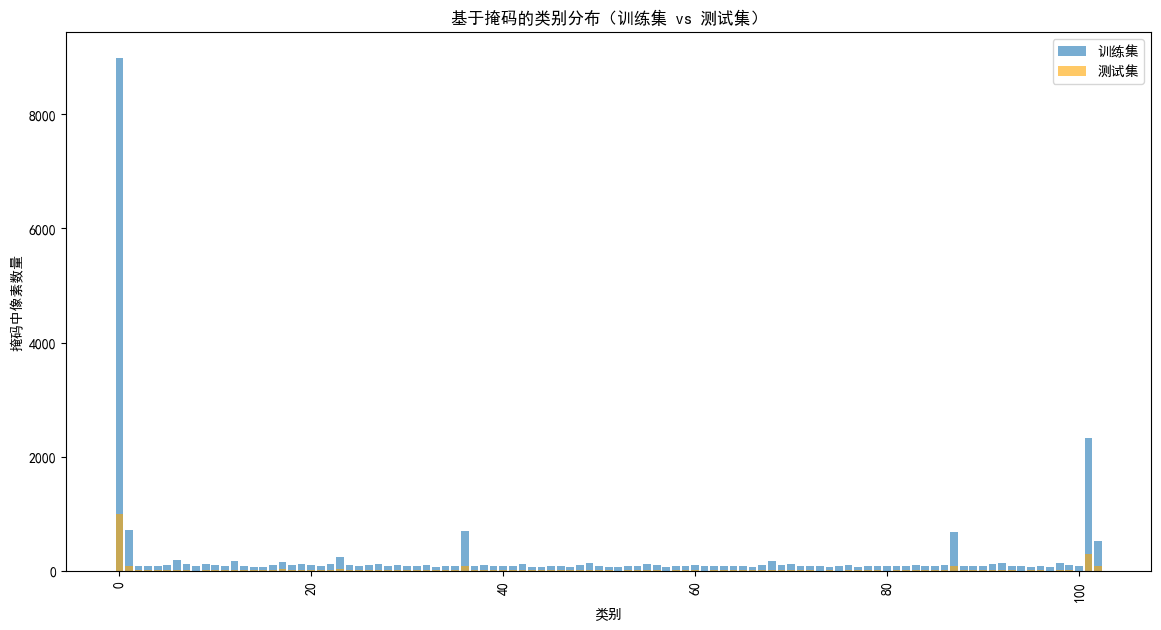

In [4]:
def plot_category_distribution(train_count, test_count):
    train_categories, train_counts = zip(*train_count.items())
    test_categories, test_counts = zip(*test_count.items())

    plt.figure(figsize=(14, 7))
    plt.bar(train_categories, train_counts, label="训练集", alpha=0.6)
    plt.bar(test_categories, test_counts, label="测试集", alpha=0.6, color='orange')
    plt.xticks(rotation=90)
    plt.xlabel("类别")
    plt.ylabel("掩码中像素数量")
    plt.title("基于掩码的类别分布（训练集 vs 测试集）")
    plt.legend()
    plt.show()

plot_category_distribution(train_count, test_count)

In [7]:
class SegNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SegNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.enc1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(2, 2, return_indices=True)

        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool5 = nn.MaxPool2d(2, 2, return_indices=True)

        # Decoder layers
        self.unpool5 = nn.MaxUnpool2d(2, 2)
        self.dec5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.unpool4 = nn.MaxUnpool2d(2, 2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256,
            kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.unpool3 = nn.MaxUnpool2d(2, 2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Encoder forward
        x, ind1 = self.pool1(self.enc1(x))
        x, ind2 = self.pool2(self.enc2(x))
        x, ind3 = self.pool3(self.enc3(x))
        x, ind4 = self.pool4(self.enc4(x))
        x, ind5 = self.pool5(self.enc5(x))

        # Decoder forward
        x = self.unpool5(x, ind5)
        x = self.dec5(x)
        x = self.unpool4(x, ind4)
        x = self.dec4(x)
        x = self.unpool3(x, ind3)
        x = self.dec3(x)
        x = self.unpool2(x, ind2)
        x = self.dec2(x)
        x = self.unpool1(x, ind1)
        x = self.dec1(x)

        return x

model = SegNet(n_channels=3,n_classes=103).to(device)




lossf = nn.CrossEntropyLoss( ignore_index=255)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
epochs_num = 10

In [8]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()

def calculate_iou(pred, mask, num_classes):
    iou = []
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()

    # 计算所有类别的 IoU，包括背景类0
    for cls in range(num_classes):
        pred_cls = pred == cls
        mask_cls = mask == cls
        intersection = np.logical_and(pred_cls, mask_cls).sum()
        union = np.logical_or(pred_cls, mask_cls).sum()
        if union == 0:
            iou.append(float('nan'))  # 避免分母为0时出错
        else:
            iou.append(intersection / union)

    return np.nanmean(iou)  # 返回所有类的平均 IoU

# 定义准确率计算函数，包括背景类0
def calculate_accuracy(pred, mask):
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    correct = (pred == mask).sum()
    total = mask.size
    return correct / total

# 训练函数
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs, num_classes):
    model.train()
    train_loss_history = []
    train_acc_history = []
    train_miou_history = []
    test_acc_history = []
    test_miou_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_miou = 0.0

        for images, masks, _ in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # 使用自动混合精度进行前向传播
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            # 混合精度反向传播和优化
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            # 计算预测
            preds = torch.argmax(outputs, dim=1)

            # 计算准确率和 IoU
            running_acc += calculate_accuracy(preds, masks)
            running_miou += calculate_iou(preds, masks, num_classes)

            # 释放无用的变量，并清理显存
            del outputs, loss, preds
            torch.cuda.empty_cache()

        # 计算每个 epoch 的平均 loss、accuracy 和 mIoU
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)
        epoch_miou = running_miou / len(train_loader)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        train_miou_history.append(epoch_miou)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Train mIoU: {epoch_miou:.4f}")

        # 在每个 epoch 后保存模型
        torch.save(model.state_dict(), f"segnet_epoch_{epoch+1}.pth")

        # 在测试集上运行评估
        test_acc, test_miou = evaluate_model(model, test_loader, device, num_classes)
        test_acc_history.append(test_acc)
        test_miou_history.append(test_miou)
        print(f"Epoch [{epoch + 1}/{epochs}], Test Accuracy: {test_acc:.4f}, Test mIoU: {test_miou:.4f}")
        visualize_predictions(model,test_loader,device,num_samples=4)
    return train_loss_history, train_acc_history, train_miou_history, test_acc_history, test_miou_history

# 测试集上的评估函数
def evaluate_model(model, test_loader, device, num_classes):
    model.eval()
    total_acc = 0.0
    total_miou = 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 计算准确率和 IoU
            total_acc += calculate_accuracy(preds, masks)
            total_miou += calculate_iou(preds, masks, num_classes)

    avg_acc = total_acc / num_batches
    avg_miou = total_miou / num_batches

    return avg_acc, avg_miou

def visualize_predictions(model, test_loader, device, num_samples=4):
    model.eval()
    with torch.no_grad():
        for images, masks, ids in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            fig, axes = plt.subplots(3, num_samples, figsize=(15, 8))
            for i in range(num_samples):
                if i < len(images):
                    # 显示原始图像
                    axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
                    axes[0, i].set_title(f"Test Image ID: {ids[i]}")
                    axes[0, i].axis('off')

                    # 显示真实掩码
                    axes[1, i].imshow(masks[i].cpu())
                    axes[1, i].set_title("Ground Truth")
                    axes[1, i].axis('off')

                    # 显示模型预测掩码
                    axes[2, i].imshow(preds[i].cpu())
                    axes[2, i].set_title("Predicted Mask")
                    axes[2, i].axis('off')

            plt.show()
            break

100%|██████████| 750/750 [25:01<00:00,  2.00s/it]  


Epoch [1/10], Train Loss: 2.8165, Train Accuracy: 0.4828, Train mIoU: 0.0224
Epoch [1/10], Test Accuracy: 0.5589, Test mIoU: 0.0356


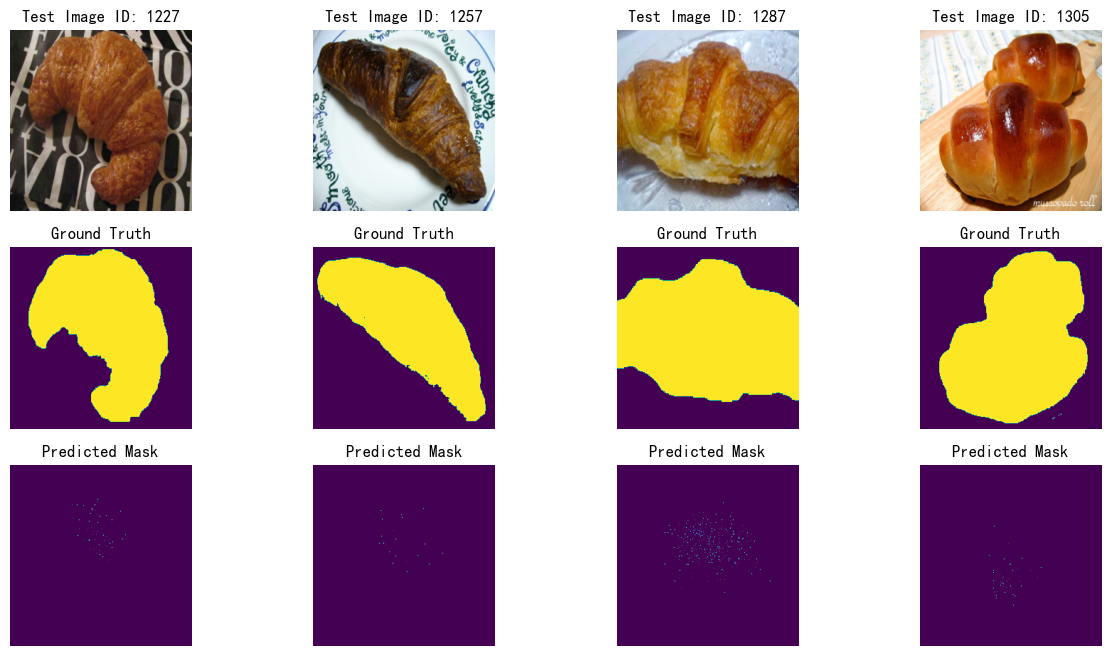

100%|██████████| 750/750 [25:44<00:00,  2.06s/it]  


Epoch [2/10], Train Loss: 2.6550, Train Accuracy: 0.5076, Train mIoU: 0.0287
Epoch [2/10], Test Accuracy: 0.5589, Test mIoU: 0.0548


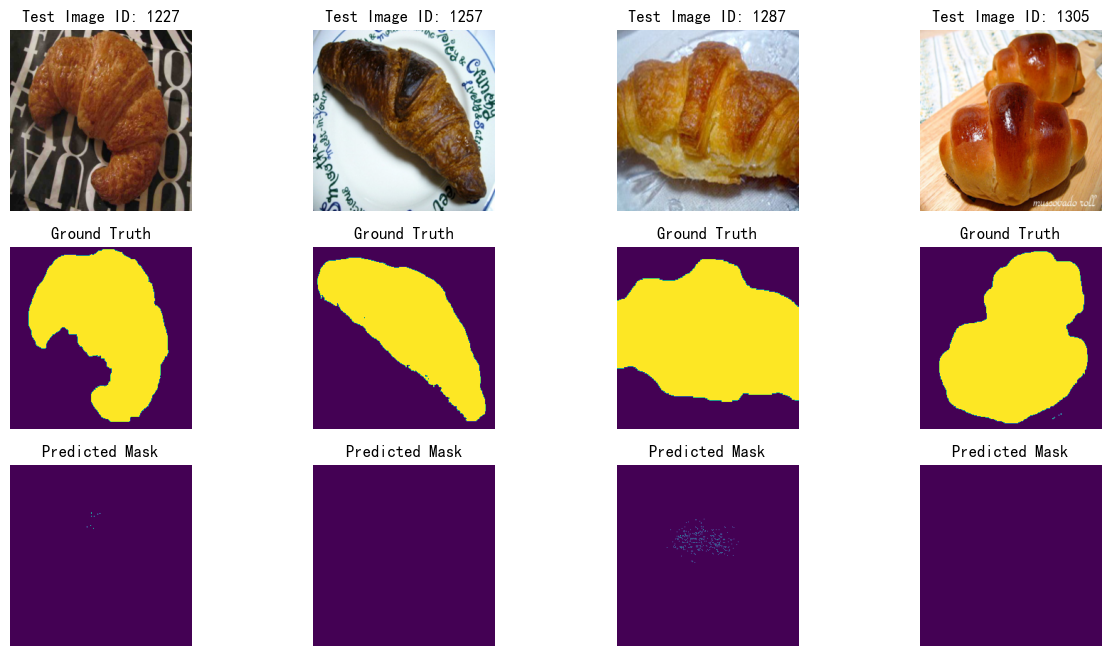

100%|██████████| 750/750 [26:00<00:00,  2.08s/it]  


Epoch [3/10], Train Loss: 2.5973, Train Accuracy: 0.5076, Train mIoU: 0.0255
Epoch [3/10], Test Accuracy: 0.5603, Test mIoU: 0.0398


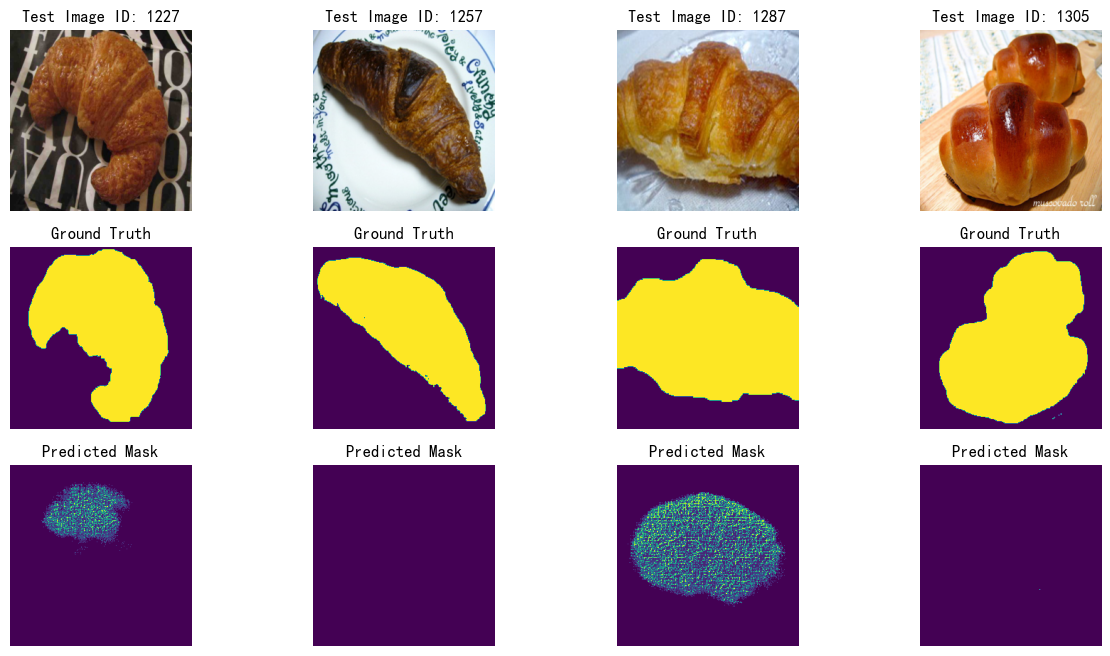

100%|██████████| 750/750 [26:00<00:00,  2.08s/it]


Epoch [4/10], Train Loss: 2.5643, Train Accuracy: 0.5081, Train mIoU: 0.0253
Epoch [4/10], Test Accuracy: 0.5604, Test mIoU: 0.0405


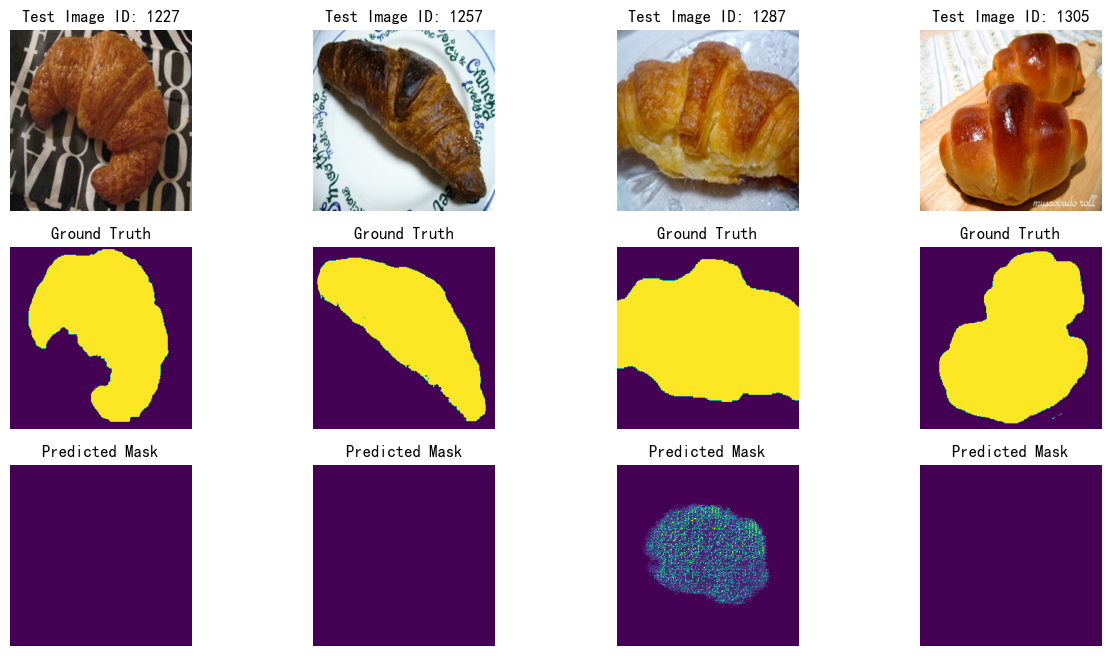

100%|██████████| 750/750 [22:22<00:00,  1.79s/it]


Epoch [5/10], Train Loss: 2.5236, Train Accuracy: 0.5096, Train mIoU: 0.0246
Epoch [5/10], Test Accuracy: 0.5606, Test mIoU: 0.0357


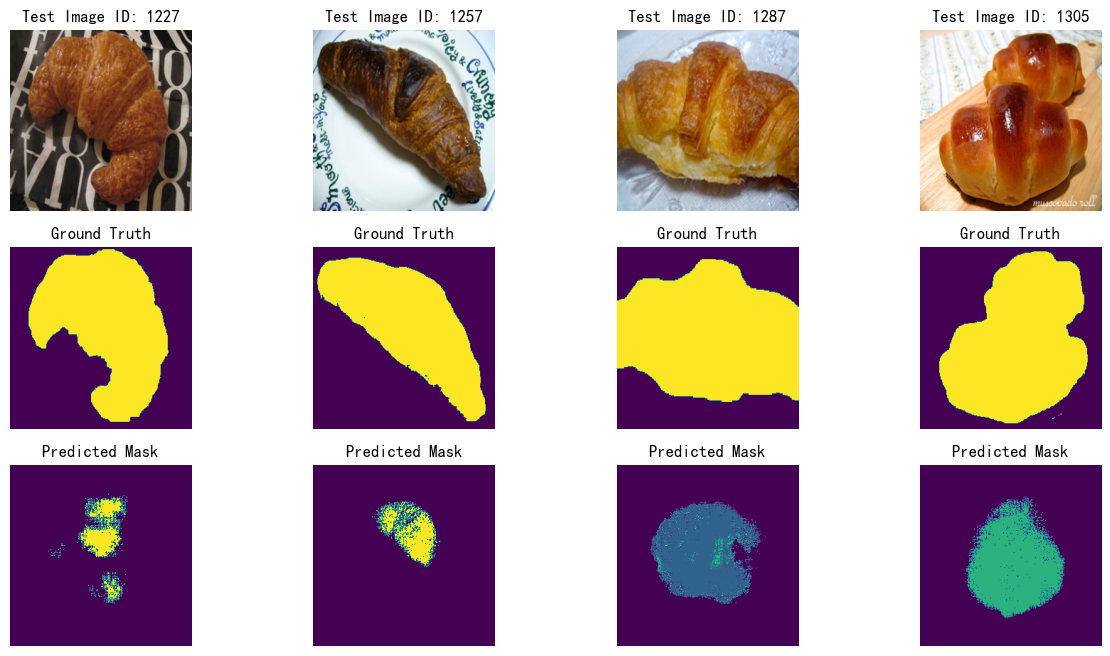

100%|██████████| 750/750 [38:23<00:00,  3.07s/it]  


Epoch [6/10], Train Loss: 2.4982, Train Accuracy: 0.5105, Train mIoU: 0.0249
Epoch [6/10], Test Accuracy: 0.5618, Test mIoU: 0.0461


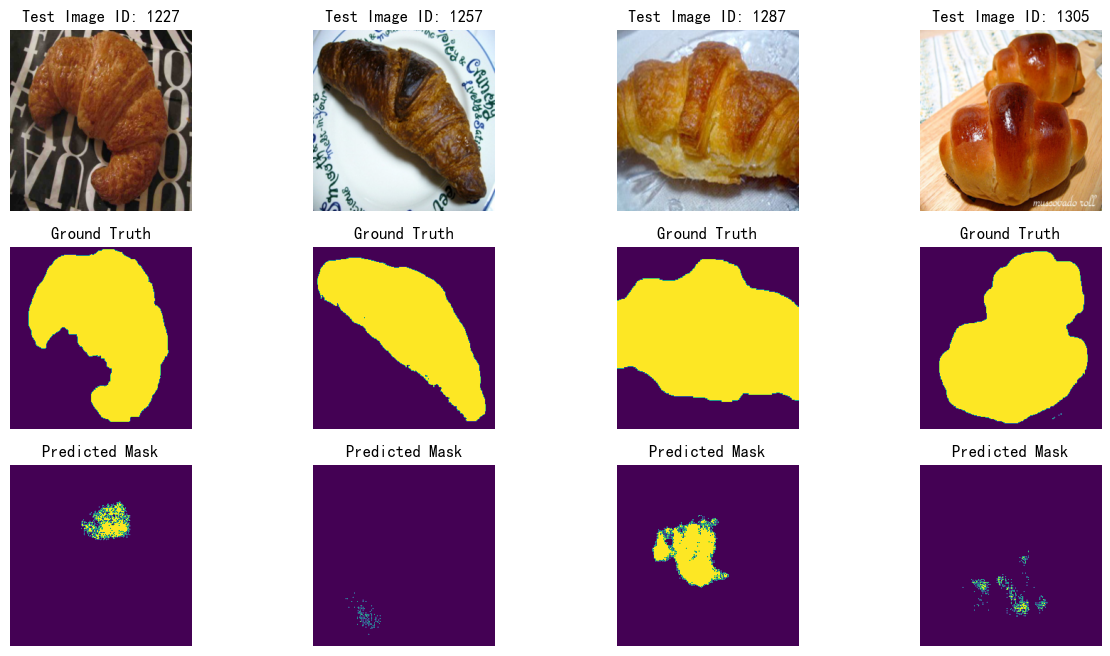

100%|██████████| 750/750 [21:51<00:00,  1.75s/it]  


Epoch [7/10], Train Loss: 2.4768, Train Accuracy: 0.5112, Train mIoU: 0.0235
Epoch [7/10], Test Accuracy: 0.5636, Test mIoU: 0.0268


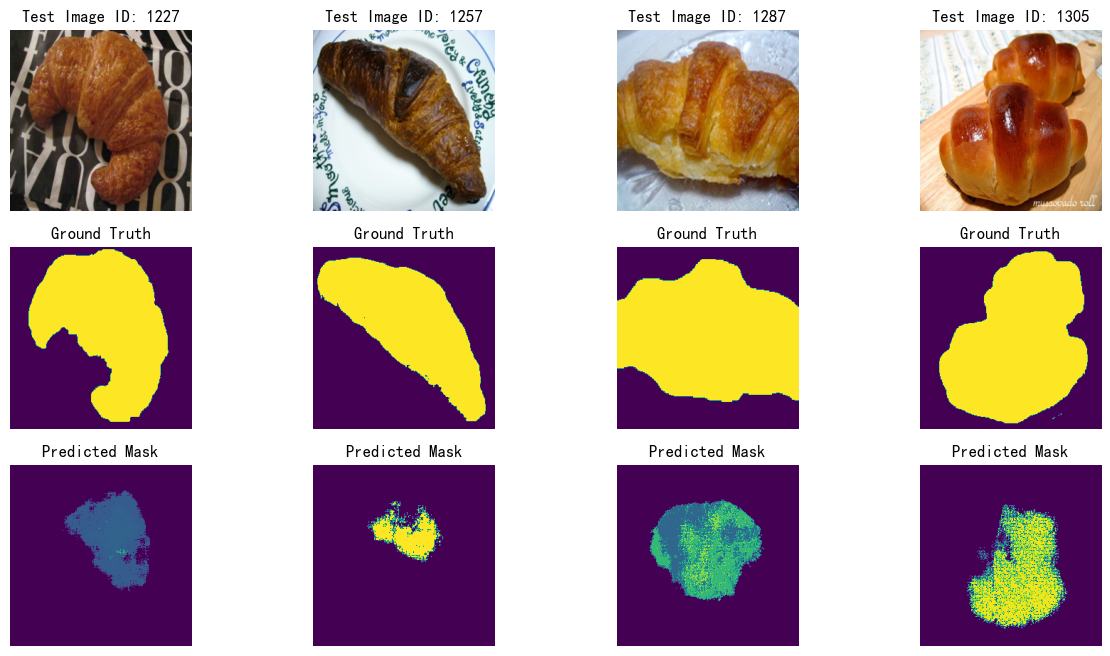

100%|██████████| 750/750 [20:51<00:00,  1.67s/it]


Epoch [8/10], Train Loss: 2.4461, Train Accuracy: 0.5124, Train mIoU: 0.0217
Epoch [8/10], Test Accuracy: 0.5648, Test mIoU: 0.0304


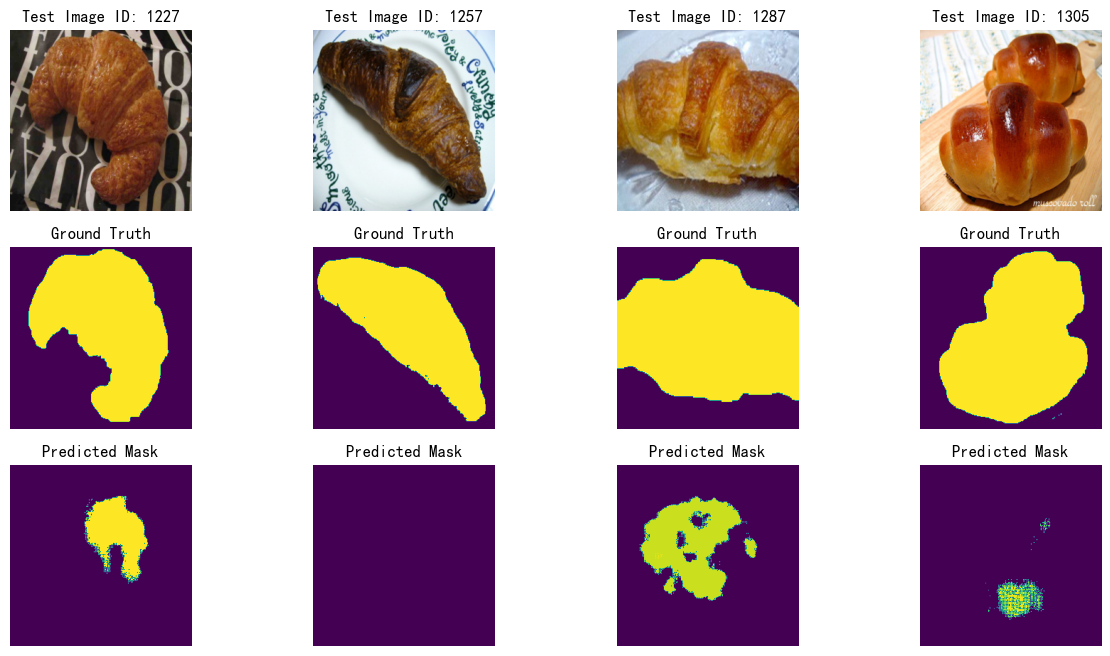

 51%|█████▏    | 386/750 [16:05<51:03,  8.42s/it]  

In [ ]:
num_classes = 103
train_loss_history, train_acc_history, train_miou_history, val_acc_history, val_miou_history = train(
    model, train_loader, test_loader, lossf, optimizer, device, epochs_num, num_classes
)